In [1]:
# # this just to make sure we are using only on CPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from tqdm import tqdm_notebook

from fastmri_recon.data.sequences.fastmri_sequences import ZeroFilled2DSequence, Masked2DSequence
from fastmri_recon.models.utils.non_linearities import lrelu
from fastmri_recon.evaluate.reconstruction.unet_reconstruction import reco_and_gt_unet_from_val_file
from fastmri_recon.evaluate.reconstruction.cross_domain_reconstruction import reco_and_gt_net_from_val_file
from fastmri_recon.evaluate.reconstruction.zero_filled_reconstruction import reco_and_gt_zfilled_from_val_file
from fastmri_recon.models.functional_models.cascading import cascade_net
from fastmri_recon.models.functional_models.kiki import kiki_net
from fastmri_recon.models.functional_models.kiki_sep import full_kiki_net
from fastmri_recon.models.functional_models.pdnet import pdnet
from fastmri_recon.models.functional_models.old_unet import unet

In [3]:
np.random.seed(0)

In [4]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.cmap'] = 'gray'

In [5]:
AF = 4

In [6]:
val_path = '/media/Zaccharie/UHRes/singlecoil_val/'
val_gen_zero = ZeroFilled2DSequence(val_path, af=AF, norm=True, mode='validation', mask_seed=0)
# val_gen_zero.filenames = val_gen_zero.filenames[:2]
val_gen_scaled = Masked2DSequence(val_path, mode='validation', af=AF, scale_factor=1e6, mask_seed=0)
# val_gen_scaled.filenames = val_gen_scaled.filenames[:2]

In [7]:
val_gen_scaled.filenames[0]

'/media/Zaccharie/UHRes/singlecoil_val/file1000000.h5'

In [8]:
all_net_params = [
    {
        'name': 'unet',
        'init_function': unet,
        'run_params': {
            'n_layers': 4,
            'pool': 'max',
            "layers_n_channels": [16, 32, 64, 128],
            'layers_n_non_lins': 2,
            'input_size': (320, 320, 1),
        },
        'val_gen': val_gen_zero,
        'run_id': 'unet_af4_1569210349',
        'reco_function': reco_and_gt_unet_from_val_file,
    },
    {
        'name': 'pdnet',
        'init_function': pdnet,
        'run_params': {
            'n_primal': 5,
            'n_dual': 5,
            'n_iter': 10,
            'n_filters': 32,
        },
        'val_gen': val_gen_scaled,
        'run_id': 'pdnet_af4_1568384763',
        'reco_function': reco_and_gt_net_from_val_file,
    },
    {
        'name': 'cascadenet',
        'init_function': cascade_net,
        'run_params': {
            'n_cascade': 5,
            'n_convs': 5,
            'n_filters': 48,
            'noiseless': True,
        },
        'val_gen': val_gen_scaled,
        'run_id': 'cascadenet_af4_1568926824',
        'reco_function': reco_and_gt_net_from_val_file,
    },
    {
        'name': 'kikinet-sep-16',
        'init_function': full_kiki_net,
        'run_params': {
            'n_convs': 16,
            'n_filters': 48,
            'noiseless': True,
            'activation': lrelu,
        },
        'val_gen': val_gen_scaled,
        'run_id': 'kikinet_sep_I2_af4_1570049560',
        'reco_function': reco_and_gt_net_from_val_file,
        'epoch': 50,
    },
]

In [9]:
image_index = 18
slice_index = 15
def unpack_model(init_function=None, run_params=None, run_id=None, epoch=300, **dummy_kwargs):
    model = init_function(**run_params)
    chkpt_path = f'../checkpoints/{run_id}-{epoch}.hdf5'
    model.load_weights(chkpt_path)
    return model

def save_figure(im_recos, img_batch, name):
    im_reco = im_recos[slice_index]
    im_gt = img_batch[slice_index]
    im_res = np.abs(im_gt - im_reco)
    fig, ax = plt.subplots(1, frameon=False)
    ax.imshow(np.abs(np.squeeze(im_reco)), aspect='auto')
    ax.axis('off')
    fig.savefig(f'figures/{name}_recon_af{AF}.png')
    fig, ax = plt.subplots(1, frameon=False)
    ax.imshow(np.abs(np.squeeze(im_res)), aspect='auto')
    ax.axis('off')
    fig.savefig(f'figures/{name}_residu_af{AF}.png')
    

def save_figure_for_params(reco_function=None, val_gen=None, name=None, **net_params):
    model = unpack_model(**net_params)
    im_recos, img_batch = reco_function(*val_gen[image_index], model)
    if val_gen == val_gen_scaled:
        im_recos /= 1e6
        img_batch /= 1e6
    save_figure(im_recos, img_batch, name)
    
    
def save_figure_zfilled():  
    im_recos, img_batch = reco_and_gt_zfilled_from_val_file(*val_gen_scaled[image_index])
    im_recos /= 1e6
    img_batch /= 1e6
    save_figure(im_recos, img_batch, 'zfilled')

<IPython.core.display.Javascript object>


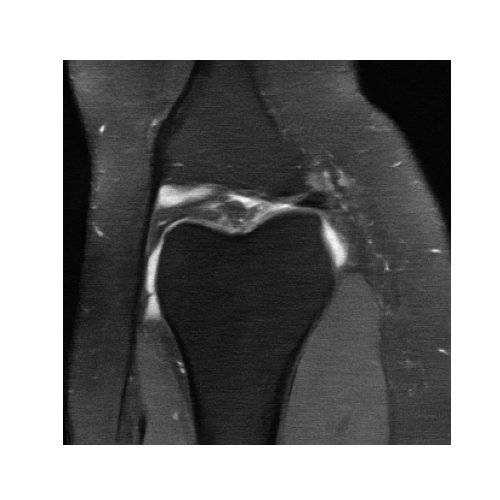

<IPython.core.display.Javascript object>


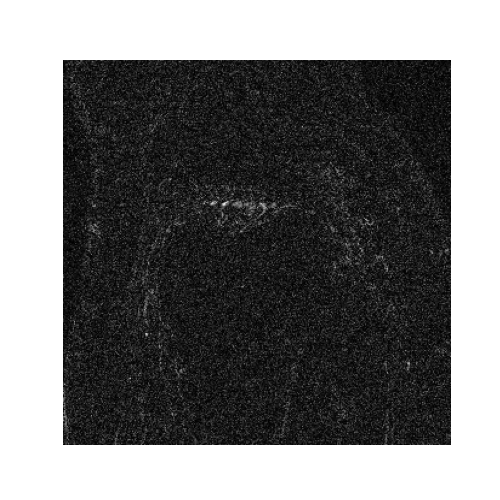

<IPython.core.display.Javascript object>


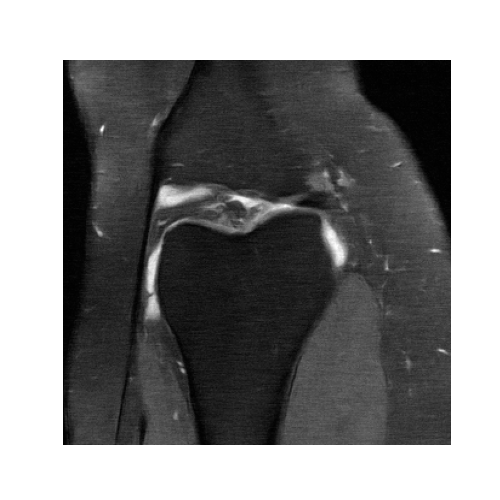

<IPython.core.display.Javascript object>


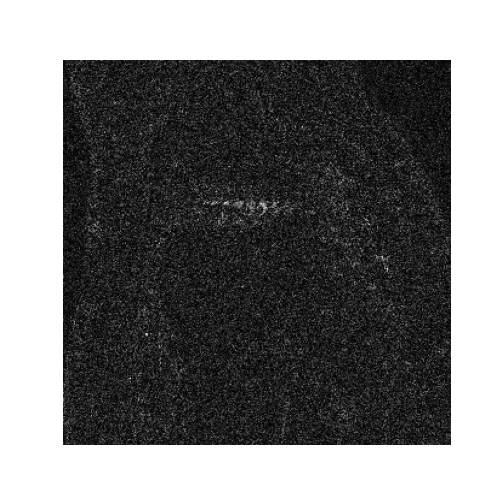

<IPython.core.display.Javascript object>


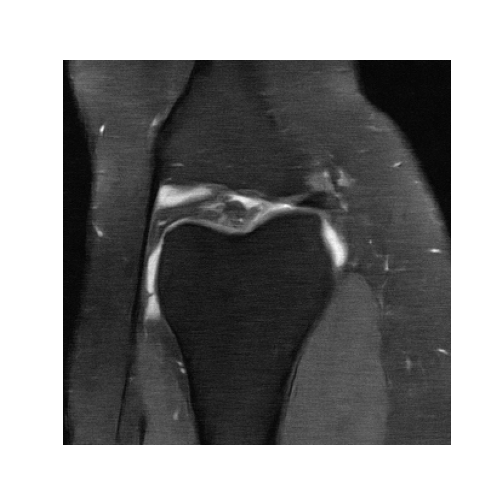

<IPython.core.display.Javascript object>


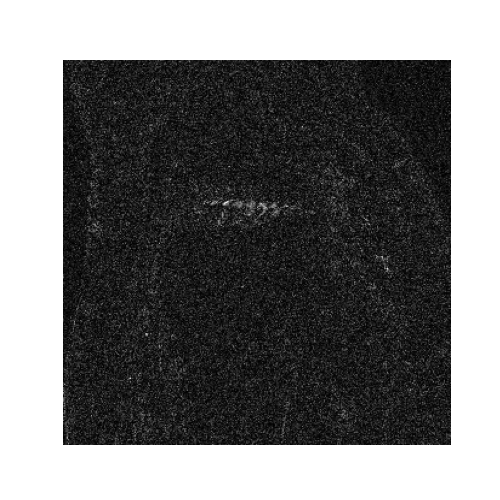

<IPython.core.display.Javascript object>


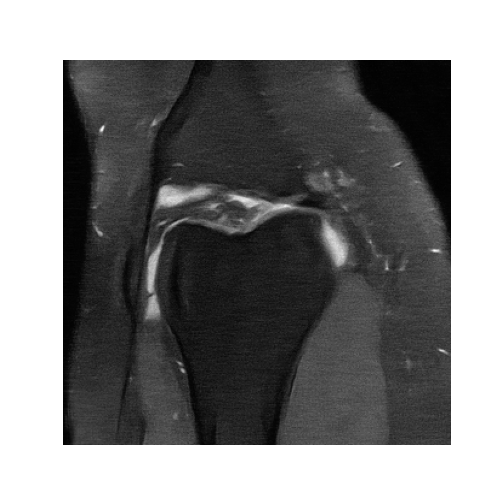

<IPython.core.display.Javascript object>


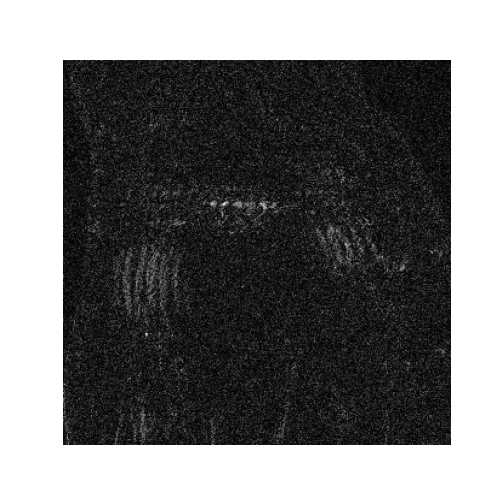

<IPython.core.display.Javascript object>


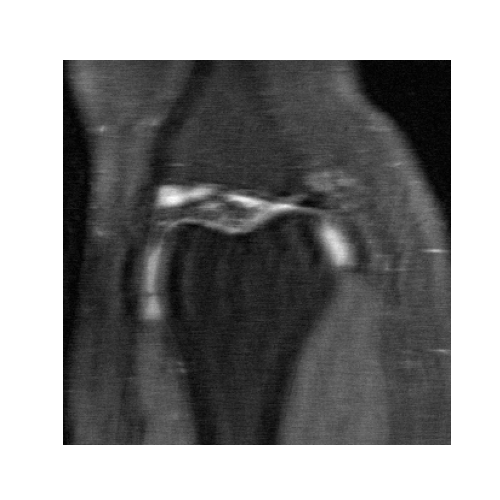

<IPython.core.display.Javascript object>


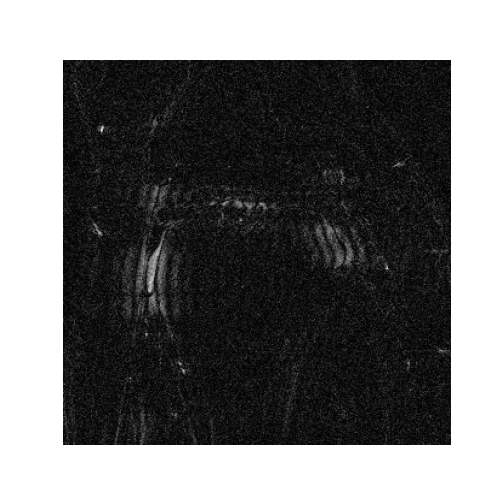

CPU times: user 43.8 s, sys: 11.7 s, total: 55.5 s
Wall time: 52.7 s


In [10]:
%%time
for net_params in all_net_params:
    save_figure_for_params(**net_params)
    
save_figure_zfilled()

<IPython.core.display.Javascript object>


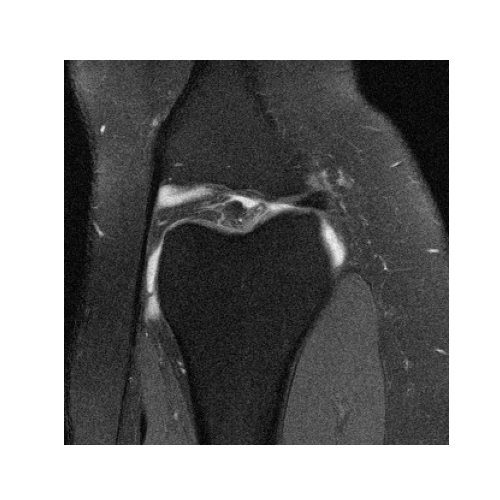

In [11]:
_, img_batch = val_gen_scaled[image_index]
img_batch /= 1e6
im_gt = img_batch[slice_index]
fig, ax = plt.subplots(1)
ax.imshow(np.abs(np.squeeze(im_gt)))
ax.axis('off')
fig.savefig(f'figures/image_gt.png')